### MCAのデータをフィッティング

ヒストグラムをMCAで得られたデータ(test.dat)から作成する。

In [1]:
gROOT->LoadMacro("../macros/b3lib.C");

In [2]:
auto h = importHist("test.dat"); // "test.dat"の部分はみなさんが作成したデータファイルの名前に置き換えてください。

size 1024


In [3]:
c = new TCanvas("can","",600,600);

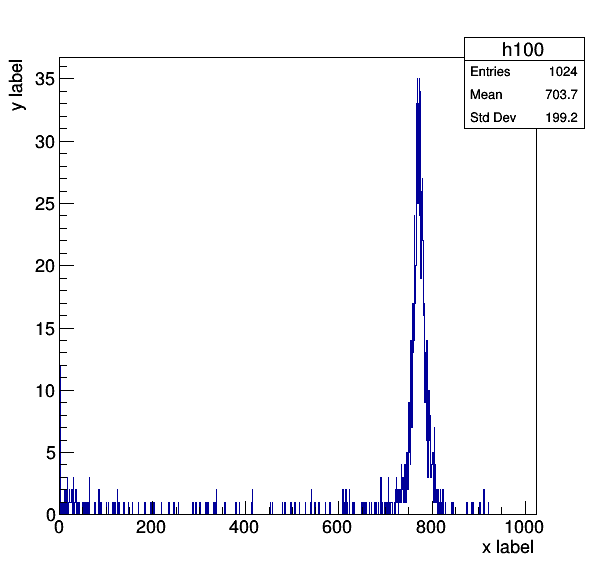

In [4]:
h->Draw();
c->Draw(); // この行は無視して良いです。

フィッティング関数の定義、ガウス分布を仮定する。  
ROOTではシステムでgaus関数が定義されているのでそれを使用する。  
gausは
$$
gaus(x) = A exp(-\frac{(x-m)^2}{2\sigma^2})
$$
gausnは規格化されたガウス関数で
$$
gausn(x) = \frac{Y}{\sqrt{2\pi}\sigma} exp(-\frac{(x-m)^2}{2\sigma^2})
$$
規格化されたガウス関数ではYがイベント数そのものに対応するためこちらを採用する。　


In [5]:
auto sg = new TF1("sg","gausn",600,1000);

最後の2引数は関数が定義されるxの範囲を指定している(今の場合600-1000ch)。


おおよそのパラメータを初期値として入力。  
SetParameters()関数でY, m, $\sigma$の順でセットする。

In [6]:
sg->SetParameters(100,800,50); // Y=100, m = 800, sigma = 50とした

フィッティングを行う。

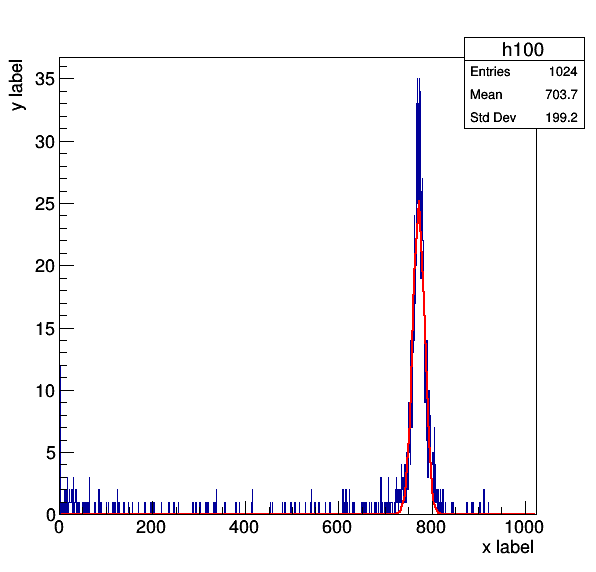

 FCN=301.443 FROM MIGRAD    STATUS=CONVERGED     144 CALLS         145 TOTAL
                     EDM=5.12851e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.95960e+02   2.82922e+01   3.51527e-01  -2.76192e-05
   2  Mean         7.72225e+02   4.59924e-01  -1.46539e-03   2.39883e-06
   3  Sigma        1.25758e+01   5.07152e-01   1.85112e-05  -3.58164e-01


In [7]:
h->Fit("sg");
h->Draw();
c->Draw(); // この行は不要。

フィッティングによりエントリー数を取得する。  
パラメータの最終結果およびその誤差を取得する関数は
```c++
    getParameter(i);
    getParError(i);
```
ここでiはi番目のパラメータを指定する。

In [8]:
double Y = sg->GetParameter(0);
double dY = sg->GetParError(0);
std::cout << Y << "+/-" << dY << std::endl;

795.96+/-28.2922


これがイベント数及びその誤差となる。

<div class="alert alert-block alert-info">
<b>実践</b><br>
ここまでのコマンドをマクロファイルとして実装してみましょう。  
</div>

### リビンしてからフィッティング
統計が少ない場合、1ch/binでヒストグラムを作成していると正しくフィッティングできないことがある。  
そこで以下にリビンを行なった後にフィッティングを行う方法をしめす。  
以下の例の場合8 ch/binとしている。

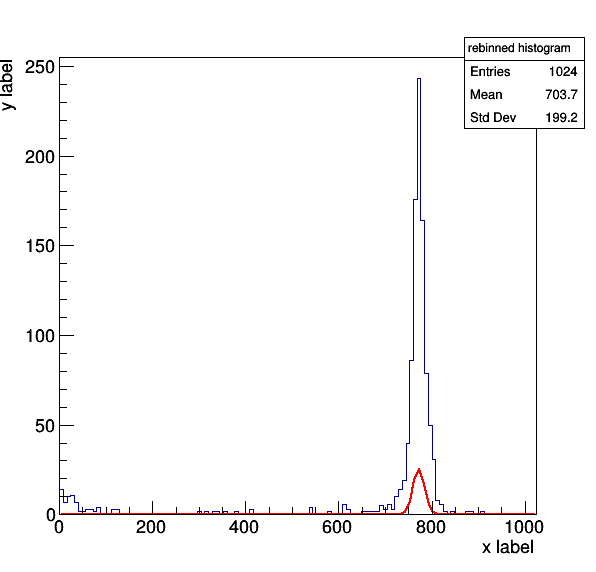

In [9]:
auto h2= rebin(h,8,"rebinned histogram"); // リビンする関数
h2->Draw();
c->Draw(); //この行は不要

フィッティング

In [10]:
sg->SetParameters(100,800,50); // Y=100, m = 800, sigma = 50とした

In [11]:
h2->Fit("sg");

 FCN=223.859 FROM MIGRAD    STATUS=CONVERGED     201 CALLS         202 TOTAL
                     EDM=2.91177e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.98529e+03   2.36397e+02   1.72944e+00   6.79756e-07
   2  Mean         7.72225e+02   5.06100e-01   3.66744e-03   2.55285e-05
   3  Sigma        1.47993e+01   5.75220e-01   2.43792e-05   5.39612e-02


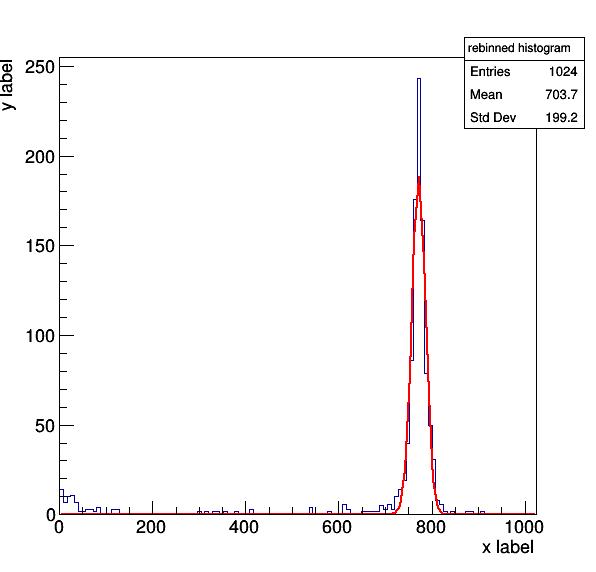

In [12]:
h2->Draw();
c->Draw();

イベント数を取得する。  
ここで注意すべきは8ch/binとしているので得られたイベント数(Y)を8で割らなければならない。

In [13]:
Y = sg->GetParameter(0)/8;
dY = sg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;


873.161+/-29.5496


### 少し複雑な関数でフィッティング
ヒストグラムを見るとわかる通りフィッティングカーブとデータの不一致が見られる。  
そこでデータをdouble gaussianでfittingしてみる。  　　
関数は以下の通り。  
中心が同じでシグマが異なる２つのガウス関数の和として定義する。  
par[4]はg1, g2の比を与えるものであり、$0 < {\rm par}[4] < 1$。  
したがって$\int (g1+g2) dx = 1$に規格化されている。

In [14]:
Double_t doubleGaus(Double_t *x, Double_t *par){
  double g1 = TMath::Gaus(x[0], par[1], par[2], kTRUE); 
  double g2 = TMath::Gaus(x[0], par[1], par[3], kTRUE); 
  return par[0]*(par[4]*g1+(1-par[4])*g2);
}

In [15]:
auto dg = new TF1("dg",doubleGaus,600,1000,5);
dg->SetParameters(1000,770,15,50,0.8);
h2->Fit("dg");

 FCN=172.582 FROM MIGRAD    STATUS=CONVERGED     166 CALLS         167 TOTAL
                     EDM=3.84262e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.40562e+03   2.41757e+02  -4.18553e-01  -1.65908e-06
   2  p1           7.71651e+02   4.69808e-01  -5.04553e-04   7.11246e-04
   3  p2           2.27296e+01   2.38647e+00   1.27828e-02  -7.91593e-04
   4  p3           8.87223e+00   1.17305e+00   8.57026e-03  -7.80605e-04
   5  p4           4.77846e-01   1.04573e-01  -5.86051e-04  -1.76855e-02


In [16]:
Y = dg->GetParameter(0)/8;
dY = dg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;

925.702+/-30.2196


全ての結果を表示させる。


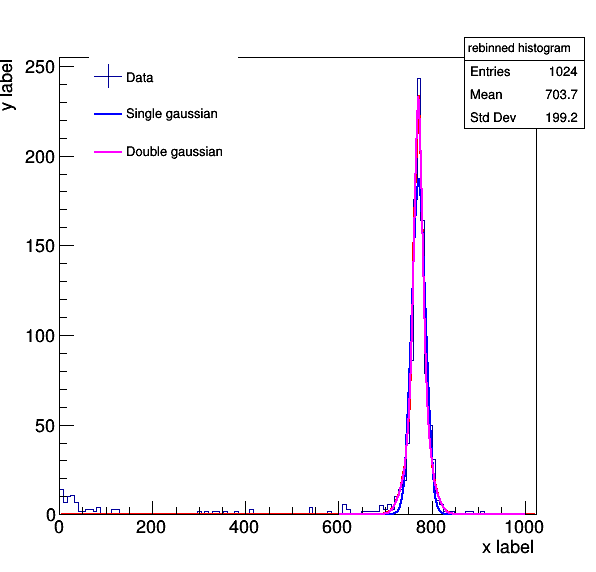

In [17]:
h2->Draw();
sg->SetLineColor(kBlue);
sg->Draw("same");
dg->SetLineColor(kMagenta);
dg->Draw("same");
auto leg = new TLegend(0.15,0.7,0.4,0.9,"","NDC");
leg->SetBorderSize(0);
leg->AddEntry(h2,"Data","lep");
leg->AddEntry(sg,"Single gaussian","l");
leg->AddEntry(dg,"Double gaussian","l");
leg->Draw();
c->Draw();